In [1]:
# image processing
from PIL import Image
from io import BytesIO
import webcolors

# data analysis
import math
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
from importlib import reload
from mpl_toolkits import mplot3d
import seaborn as sns

# modeling
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [2]:
import logging
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)
sns.set(style="ticks", color_codes=True)
pd.options.display.float_format = '{:.3f}'.format

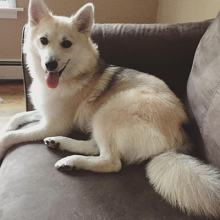

In [89]:
ori_img = Image.open("Sample.png")
ori_img

In [90]:
X = np.array(ori_img.getdata())
ori_pixels = X.reshape(*ori_img.size, -1)
ori_pixels.shape

(220, 220, 3)

In [91]:
def imageByteSize(img):
    img_file = BytesIO()
    image = Image.fromarray(np.uint8(img))
    image.save(img_file, 'png')
    return img_file.tell()/1024

ori_img_size = imageByteSize(ori_img)
ori_img_size

73.57421875

In [92]:
ori_img_n_colors = len(set(ori_img.getdata()))
ori_img_n_colors

19531

In [93]:
ori_img_total_variance = sum(np.linalg.norm(X - np.mean(X, axis = 0), axis = 1)**2)
ori_img_total_variance

369718958.09813595

In [94]:
#import PIL.Image
#rgba_image = PIL.Image.open("Sample.png")
#ori_img = rgba_image.convert('RGB')
#ori_img

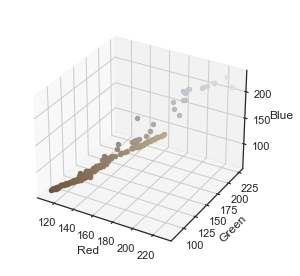

In [95]:
reload(plt)
fig = plt.figure("3-D Plot of Image")
ax = plt.axes(projection='3d')
for px in X[:ori_pixels.shape[0]]:
    ax.scatter3D(*px, c = np.array([px])/255)
ax.set_xlabel("Red")
ax.set_ylabel("Green")
ax.set_zlabel("Blue")
ax.dist = 11
plt.tight_layout()
plt.show()

In [96]:
kmeans = KMeans(n_clusters = 2,
                n_jobs = -1,
                random_state = 123).fit(X)
kmeans_df = pd.DataFrame(kmeans.cluster_centers_, columns = ['Red', 'Green', 'Blue'])
kmeans_df

D:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


,Red,Green,Blue
0,81.862,67.910,58.434
1,165.963,154.946,141.109


In [97]:
def closest_colour(requested_colour):
    min_colours = {}
    for key, name in webcolors.CSS3_HEX_TO_NAMES.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

def get_colour_name(requested_colour):
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
    return closest_name

In [98]:
kmeans_df["Color Name"] = list(map(get_colour_name, np.uint8(kmeans.cluster_centers_)))
kmeans_df

,Red,Green,Blue,Color Name
0,81.862,67.910,58.434,darkolivegreen
1,165.963,154.946,141.109,rosybrown


In [99]:
def replaceWithCentroid(kmeans):
    new_pixels = []
    for label in kmeans.labels_:
        pixel_as_centroid = list(kmeans.cluster_centers_[label])
        new_pixels.append(pixel_as_centroid)
    new_pixels = np.array(new_pixels).reshape(*ori_img.size, -1)
    return new_pixels

new_pixels = replaceWithCentroid(kmeans)

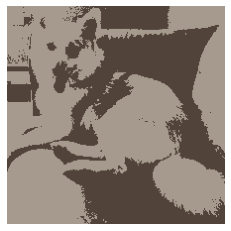

In [100]:
def plotImage(img_array, size):
    reload(plt)
    plt.imshow(np.array(img_array/255).reshape(*size))
    plt.axis('off')
    return plt
    
plotImage(new_pixels, new_pixels.shape).show()

In [101]:
def calculateBCSS(X, kmeans):
    _, label_counts = np.unique(kmeans.labels_, return_counts = True)
    diff_cluster_sq = np.linalg.norm(kmeans.cluster_centers_ - np.mean(X, axis = 0), axis = 1)**2
    return sum(label_counts * diff_cluster_sq)

WCSS = kmeans.inertia_
BCSS = calculateBCSS(X, kmeans)
exp_var = 100*BCSS/(WCSS + BCSS)
print("WCSS: {}".format(WCSS))
print("BCSS: {}".format(BCSS))
print("Explained Variance: {:.3f}%".format(exp_var))
print("Image Size: {:.3f} KB".format(imageByteSize(new_pixels)))

WCSS: 118277892.50795639
BCSS: 251485829.90653878
Explained Variance: 68.013%
Image Size: 3.879 KB


In [102]:
range_k_clusters = (2, 21)

kmeans_result = []
for k in range(*range_k_clusters):
    # CLUSTERING
    kmeans = KMeans(n_clusters = k,
                    n_jobs = -1,
                    random_state = 123).fit(X)
    
    # REPLACE PIXELS WITH ITS CENTROID
    new_pixels = replaceWithCentroid(kmeans)
    
    # EVALUATE
    WCSS = kmeans.inertia_
    BCSS = calculateBCSS(X, kmeans)
    exp_var = 100*BCSS/(WCSS + BCSS)
    
    metric = {
        "No. of Colors": k,
        "Centroids": list(map(get_colour_name, np.uint8(kmeans.cluster_centers_))),
        "Pixels": new_pixels,
        "WCSS": WCSS,
        "BCSS": BCSS,
        "Explained Variance": exp_var,
        "Image Size (KB)": imageByteSize(new_pixels)
    }
    
    kmeans_result.append(metric)
kmeans_result = pd.DataFrame(kmeans_result).set_index("No. of Colors")
kmeans_result

D:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
D:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
D:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
D:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
D:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be re

,Centroids,Pixels,WCSS,BCSS,Explained Variance,Image Size (KB)
No. of Colors,,,,,,
2,"[darkolivegreen, rosybrown]","[[[165.9626299030712, 154.94649917771113, 141....",118277892.508,251485829.907,68.013,3.879
3,"[gray, darkgray, darkslategray]","[[[182.8486496742732, 175.57042565302055, 163....",57201325.902,311978056.123,84.506,6.081
4,"[dimgray, silver, rosybrown, darkslategray]","[[[202.93065866371865, 199.29158110882852, 191...",31972165.965,337061745.978,91.336,7.270
5,"[dimgray, rosybrown, lightgray, gray, darkslat...","[[[209.04022988505852, 206.27607492550004, 199...",23196490.567,346249828.973,93.721,9.556
6,"[dimgray, darkgray, darkslategray, gainsboro, ...","[[[219.25728500355456, 217.88450604122283, 213...",16714814.654,351718845.284,95.463,11.121
7,"[darkslategray, rosybrown, darkgray, dimgray, ...","[[[220.9143635655906, 219.7925262748155, 215.5...",12842594.816,357183593.683,96.529,12.506
8,"[gray, darkslategray, gainsboro, silver, darks...","[[[190.13401430030743, 184.79611848825374, 174...",10474432.706,359168161.603,97.166,14.281
9,"[darkslategray, rosybrown, gainsboro, dimgray,...","[[[196.63112866074454, 192.49555774926, 184.30...",9000287.707,361494086.533,97.571,15.834
10,"[rosybrown, darkslategray, dimgray, gainsboro,...","[[[196.57661558960777, 192.42838107928083, 184...",7889586.735,361576020.067,97.865,17.403


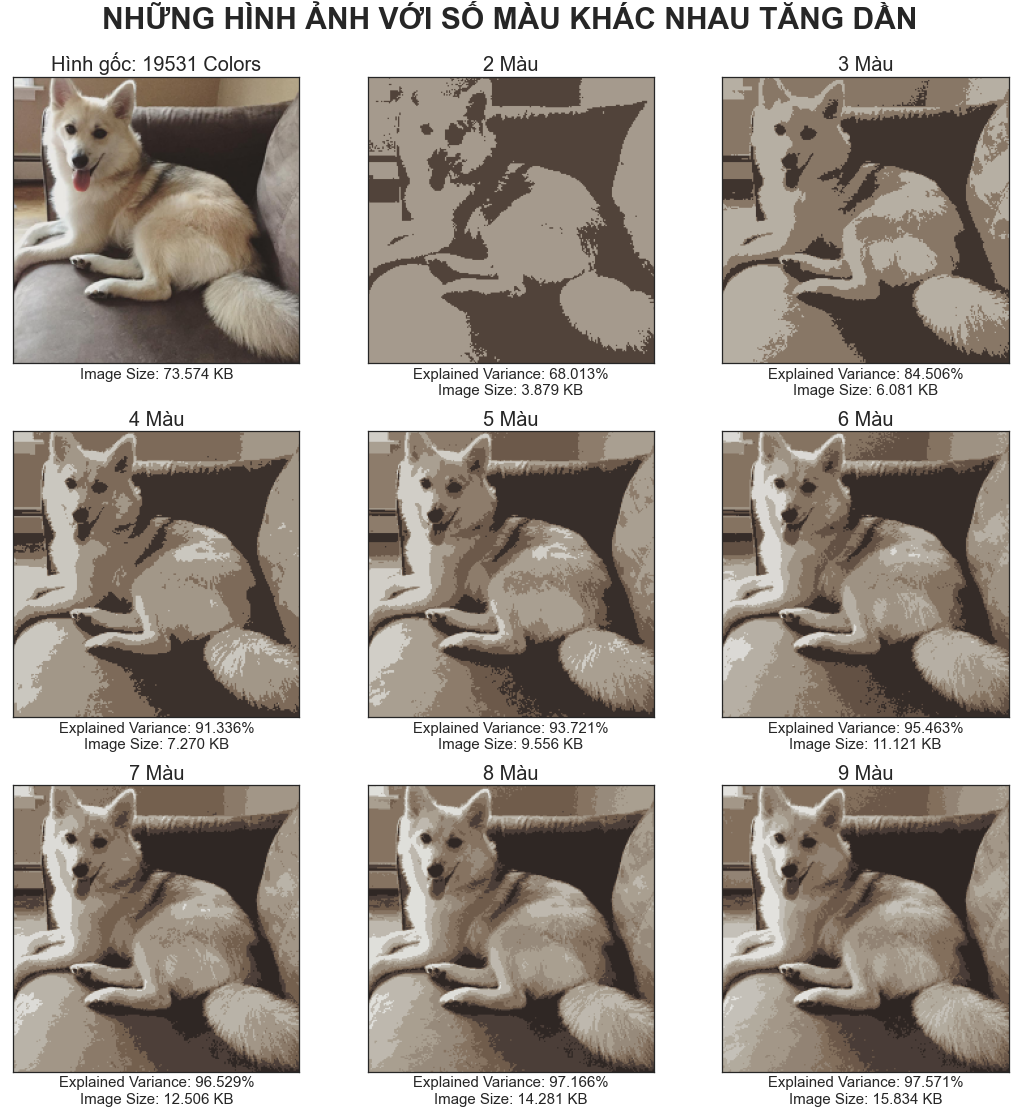

In [115]:
fig, axes = plt.subplots(3, 3, figsize=(15,15))

# PLOT ORIGINAL IMAGE
axes[0][0].imshow(X.reshape(*ori_img.size, 3))
axes[0][0].set_title("Hình gốc: {} Colors".format(ori_img_n_colors), fontsize = 20)
axes[0][0].set_xlabel("Image Size: {:.3f} KB".format(ori_img_size), fontsize = 15)
axes[0][0].set_xticks([])
axes[0][0].set_yticks([])

# PLOT COLOR-REDUCED IMAGE
for ax, k, pixels in zip(axes.flat[1:], kmeans_result.index, kmeans_result["Pixels"]):
    compressed_image = np.array(pixels/255).reshape(*ori_img.size, 3)
    ax.imshow(compressed_image)
    ax.set_title("{} Màu".format(k), fontsize=20)
    ax.set_xlabel("Explained Variance: {:.3f}%\nImage Size: {:.3f} KB".format(kmeans_result.loc[k, "Explained Variance"],
                                                                              kmeans_result.loc[k, "Image Size (KB)"]),
                  fontsize=15)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
fig.suptitle("NHỮNG HÌNH ẢNH VỚI SỐ MÀU KHÁC NHAU TĂNG DẦN", size = 30, y = 1.03, fontweight = "bold")
plt.show()

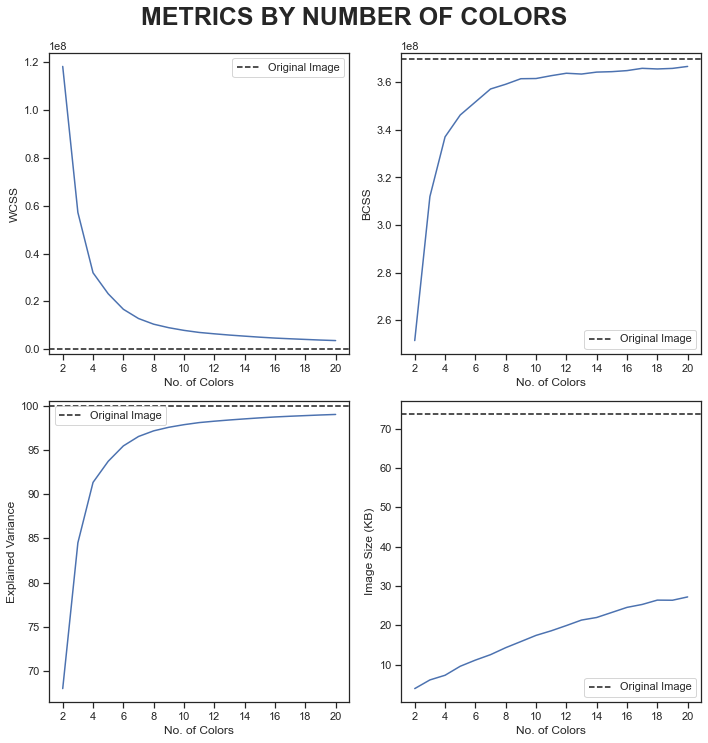

In [104]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))
for ax, metric in zip(axes.flat, kmeans_result.columns[2:]):
    sns.lineplot(x = kmeans_result.index, y = metric, data = kmeans_result, ax = ax)
    
    if metric == "WCSS":
        y_val = 0
    elif metric == "BCSS":
        y_val = ori_img_total_variance
    elif metric == "Explained Variance":
        y_val = 100
    elif metric == "Image Size (KB)":
        y_val = ori_img_size
    
    ax.axhline(y = y_val, color = 'k', linestyle = '--', label = "Original Image")
    ax.set_xticks(kmeans_result.index[::2])
    ax.ticklabel_format(useOffset = False)
    ax.legend()
plt.tight_layout()
fig.suptitle("METRICS BY NUMBER OF COLORS", size = 25, y = 1.03, fontweight = "bold")
plt.show()

In [105]:
def locateOptimalElbow(x, y):
    # START AND FINAL POINTS
    p1 = (x[0], y[0])
    p2 = (x[-1], y[-1])
    
    # EQUATION OF LINE: y = mx + c
    m = (p2[1] - p1[1]) / (p2[0] - p1[0])
    c = (p2[1] - (m * p2[0]))````````````````````
    
    # DISTANCE FROM EACH POINTS TO LINE mx - y + c = 0
    a, b = m, -1
    dist = np.array([abs(a*x0+b*y0+c)/math.sqrt(a**2+b**2) for x0, y0 in zip(x,y)])
    return np.argmax(dist) + x[0]

In [106]:
def calculateDerivative(data):
    derivative = []
    for i in range(len(data)):
        if i == 0:
            # FORWARD DIFFERENCE
            d = data[i+1] - data[i]
        elif i == len(data) - 1:
            # BACKWARD DIFFERENCE
            d = data[i] - data[i-1]
        else:
            # CENTER DIFFERENCE
            d = (data[i+1] - data[i-1])/2
        derivative.append(d)
    return np.array(derivative)

def locateDrasticChange(x, y):
    # CALCULATE GRADIENT BY FIRST DERIVATIVE
    first_derivative = calculateDerivative(np.array(y))
    
    # CALCULATE CHANGE OF GRADIENT BY SECOND DERIVATIVE
    second_derivative = calculateDerivative(first_derivative)

    return np.argmax(np.abs(second_derivative)) + x[0]

In [107]:
optimal_k = []
for col in kmeans_result.columns[2:]:
    optimal_k_dict = {}
    optimal_k_dict["Metric"] = col
    if col == "Image Size (KB)":
        optimal_k_dict["Method"] = "Derivative"
        optimal_k_dict["Optimal k"] = locateDrasticChange(kmeans_result.index, kmeans_result[col].values)
    else:
        optimal_k_dict["Method"] = "Elbow"
        optimal_k_dict["Optimal k"] = locateOptimalElbow(kmeans_result.index, kmeans_result[col].values)
    optimal_k.append(optimal_k_dict)
optimal_k = pd.DataFrame(optimal_k)
optimal_k

,Metric,Method,Optimal k
0,WCSS,Elbow,6
1,BCSS,Elbow,5
2,Explained Variance,Elbow,6
3,Image Size (KB),Derivative,2


In [108]:
k_opt = optimal_k["Optimal k"].max()
k_opt

6

In [109]:
ori = {
    "Type": "Original",
    "Pixels": X,
    "No. of Colors": ori_img_n_colors,
    "Image Size (KB)": ori_img_size,
    "Explained Variance": 100
}
color_reduced = {
    "Type": "Color-Reduced",
    "Pixels": kmeans_result.loc[k_opt, "Pixels"],
    "No. of Colors": k_opt,
    "Image Size (KB)": kmeans_result.loc[k_opt, "Image Size (KB)"],
    "Explained Variance": kmeans_result.loc[k_opt, "Explained Variance"]
}
ori_vs_kmeans = pd.DataFrame([ori, color_reduced]).set_index("Type")
ori_vs_kmeans

,Pixels,No. of Colors,Image Size (KB),Explained Variance
Type,,,,
Original,"[[195, 201, 208], [194, 201, 207], [191, 198, ...",19531,73.574,100.000
Color-Reduced,"[[[219.25728500355456, 217.88450604122283, 213...",6,11.121,95.463


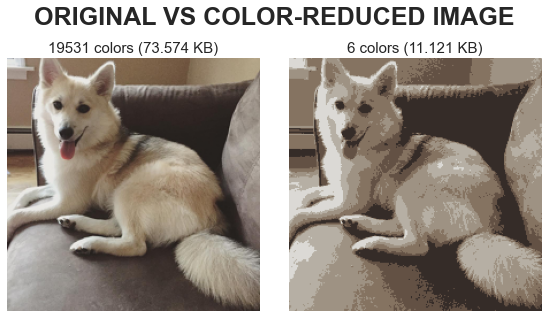

In [110]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
for ax, (typ, row) in zip(axes.flat, ori_vs_kmeans.iterrows()):
    img_array = np.array(row["Pixels"]/255)
    ax.imshow(img_array.reshape(*ori_img.size, 3))
    ax.axis("off")
    ax.set_title("{} colors ({:.3f} KB)".format(row["No. of Colors"], row["Image Size (KB)"]), fontsize=15)
plt.tight_layout()
fig.suptitle("ORIGINAL VS COLOR-REDUCED IMAGE", size = 25, y = 1.1, fontweight = "bold")
plt.show()

In [111]:
relative_size = ori_vs_kmeans.loc["Color-Reduced", "Image Size (KB)"]/ori_vs_kmeans.loc["Original", "Image Size (KB)"]
print("Reduction: {:.3f}% from original image size".format((1-relative_size)*100))
print("Explained Variance: {:.3f}%".format(ori_vs_kmeans.loc["Color-Reduced", "Explained Variance"]))

Reduction: 84.885% from original image size
Explained Variance: 95.463%
